In [1]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm

In [2]:
class Autoencoder():
    def __init__(self, input_neuron, encoding_neuron, learning_rate, alpha):
        self.input_neuron = input_neuron
        self.encoding_neuron = encoding_neuron
        self.learning_rate = learning_rate
        self.alpha = alpha

        self.weights_input_encoding = np.random.rand(input_neuron, encoding_neuron)
        self.weights_encoding_input = np.random.rand(encoding_neuron, input_neuron)
        self.bias_encoding = np.random.rand(1, encoding_neuron)
        self.bias_input = np.random.rand(1, input_neuron)

        self.prev_delta_weights_input_encoding = np.zeros((input_neuron, encoding_neuron))
        self.prev_delta_weights_encoding_input = np.zeros((encoding_neuron, input_neuron))
        self.prev_delta_bias_encoding = np.zeros((1, encoding_neuron))
        self.prev_delta_bias_input = np.zeros((1, input_neuron))

        self.errors = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def encode(self, inputs):
        self.encoding_layer_input = np.dot(inputs, self.weights_input_encoding) + self.bias_encoding
        self.encoding_layer_output = self.sigmoid(self.encoding_layer_input)

    def decode(self, encoding_output):
        self.input_layer_input = np.dot(encoding_output, self.weights_encoding_input) + self.bias_input
        self.input_layer_output = self.sigmoid(self.input_layer_input)

    def backward_pass(self, inputs):
        encoding_error = inputs - self.input_layer_output
        encoding_delta = encoding_error * self.sigmoid_derivative(self.input_layer_output)

        delta_weights_encoding_input = self.learning_rate * np.dot(self.encoding_layer_output.T, encoding_delta) / inputs.shape[0] + self.alpha * self.prev_delta_weights_encoding_input
        delta_bias_input = self.learning_rate * np.mean(encoding_delta, axis=0, keepdims=True) + self.alpha * self.prev_delta_bias_input

        self.weights_encoding_input += delta_weights_encoding_input
        self.bias_input += delta_bias_input

        decoding_error = encoding_delta.dot(self.weights_encoding_input.T)
        decoding_delta = decoding_error * self.sigmoid_derivative(self.encoding_layer_output)

        delta_weights_input_encoding = self.learning_rate * np.dot(inputs.T, decoding_delta) / inputs.shape[0] + self.alpha * self.prev_delta_weights_input_encoding
        delta_bias_encoding = self.learning_rate * np.mean(decoding_delta, axis=0, keepdims=True) + self.alpha * self.prev_delta_bias_encoding

        self.weights_input_encoding += delta_weights_input_encoding
        self.bias_encoding += delta_bias_encoding

        self.prev_delta_weights_input_encoding = delta_weights_input_encoding
        self.prev_delta_weights_encoding_input = delta_weights_encoding_input
        self.prev_delta_bias_encoding = delta_bias_encoding
        self.prev_delta_bias_input = delta_bias_input

        mse = np.mean((inputs - self.input_layer_output) ** 2)
        self.errors.append(mse)

    def train(self, inputs, epochs=10):
        for _ in tqdm(range(epochs)):
            self.encode(inputs)
            self.decode(self.encoding_layer_output)
            self.backward_pass(inputs)

    def encode_data(self, inputs_data):
        self.encode(inputs_data)
        return self.encoding_layer_output

    def decode_data(self, encoded_data):
        self.decode(encoded_data)
        return self.input_layer_output

In [3]:
df = pd.read_csv(r"./abalone.csv", header=None)
df[0] = df[0].replace({'M': 0, 'F': 1, 'I': 2})
X = df.iloc[1:, :-1].values
df.head()

,0,1,2,3,4,5,6,7,8
0,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
1,0,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15
2,0,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7
3,1,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9
4,0,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
autoencoder = Autoencoder(input_neuron=X.shape[1], encoding_neuron=5, learning_rate=1, alpha=0.9)
autoencoder.train(X, epochs=1000)
X_encode_data = autoencoder.encode_data(X)
X_decode_data = autoencoder.decode_data(X_encode_data)

print(mean_squared_error(X, X_decode_data))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.22it/s]

0.5840759990181555


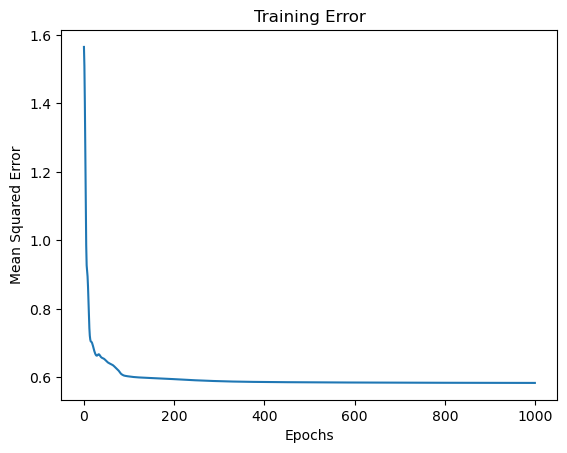

In [6]:
plt.plot(autoencoder.errors)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Error')
plt.show()